In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mphelper import ProcessWrapPool
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
from collections import defaultdict
from biodata.delimited import DelimitedWriter
import pybedtools
from pathlib import Path
import sys
import pandas as pd
from biodatatools.utils.common import json_load
import aldentools.plot as ap
from biodataplot.genomeview import plot_genome_view
import matplotlib.lines as mlines

In [3]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [4]:
sys.path.append(str(Path.cwd().parent))
import utils

In [5]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/kl945/EnhancerAtlas/PROcap/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/genomes/human/"

# Pause distance changes across tissues

In [6]:
ks = ["pl", "mn"]
ds = ["distal", "proximal"]

In [7]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [8]:
inputfile = f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt"
samples = list(pd.read_table(inputfile, header=None)[0])
len(samples)

93

In [32]:
# Blood: no permeabilization

tissues = defaultdict(list)
for s in samples:
	t = labels[s][1]
	if t != "Blood":
	    tissues[t].append(s)
len(tissues)

14

In [10]:
peak_beds = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_beds.json")

In [11]:
pause_distance_beds = {}
for t in tissues:
	for s in tissues[t]:
		prefix = peak_beds[s][0].split("/")[-1].split("_1_")[0]
		pause_distance_beds[s] = [f"{PROJECT_DIR_d2}Alignments/{prefix}_d{k}.bed.bgz" for k in ks]

In [32]:
def get_reads_in_defined_regions(s):
	# Combine pausing distance on forward and reverse strands
	b1 = pybedtools.BedTool(pause_distance_beds[s][0])
	b2 = pybedtools.BedTool(pause_distance_beds[s][1])
	chroms = [f"chr{n}" for n in range(1,23)]+["chrX"]
	b_pause = b1.cat(b2, postmerge=False).filter(lambda x: x.chrom in chroms).saveas()
	# Combine divergent and unidirectional elements
	b1 = pybedtools.BedTool(peak_beds[s][0])
	b2 = pybedtools.BedTool(peak_beds[s][1])
	b_es = b1.cat(b2)
	# Focus on reads found in PRO-cap elements
	keep = set([tuple(i.fields) for i in b_pause.intersect(b_es, u=True)])
	# Separate them into distal and proximal
	for d in ds:
		outputfile = f"{PROJECT_DIR_o}temp/{s}_{d}_pausing_distance.bed.bgz"
		records = [i.fields for i in b_pause.intersect(tss, v=True) if tuple(i.fields) in keep] if d == "distal" else [i.fields for i in b_pause.intersect(tss, u=True) if tuple(i.fields) in keep]
		with DelimitedWriter(outputfile) as dw:
			for record in records:
				dw.write(record)

In [35]:
pwpool = ProcessWrapPool(10)

tss = pybedtools.BedTool(f'{PROJECT_DIR_r}gencode.v37.annotation.TSS.500.bed.bgz')
for s in pause_distance_beds:
	pwpool.run(get_reads_in_defined_regions, args=[s])

In [18]:
len(pwpool.finished_tasks)

In [17]:
pwpool.close()

In [12]:
# Get pause distances for each sample

pwpool = ProcessWrapPool(10)

map_dict = {}
for s, d in itertools.product(list(pause_distance_beds), ds):
	inputfile = f"{PROJECT_DIR_o}temp/{s}_{d}_pausing_distance.bed.bgz"
	map_dict[(s,d)] = pwpool.run(utils.get_pause_distances, args=[inputfile])

In [19]:
len(pwpool.finished_tasks)

152

In [27]:
temp = pwpool.get()
pause_distances = {}
for k in map_dict:
	pause_distances[k] = temp[map_dict[k]]

In [21]:
pwpool.close()

# Overall pattern

In [22]:
groups = {"Early": ["Pancreas", "Small intestine", "Large intestine", "Lymph node", "Testis", "Spleen", "Liver"],
		 "Intermediate": ["Brain", "Lung", "Adrenal gland"],
		 "Late": ["Breast", "Muscle", "Ovary", "Heart"]
		}

In [23]:
medians = defaultdict(list)
for d in ds:
	medians[d] = defaultdict(list)
	for t in tissues:
		for s in tissues[t]:
			values = list(pause_distances[(s,d)].elements())
			medians[d][t].append(np.median(values))

In [24]:
medians_sorted = {}
for d in ds:
	medians_sorted[d] = dict(sorted(medians[d].items(), key=lambda item: np.median(item[1])))

In [25]:
for d in ds:
	fig, ax = plt.subplots()
	plt.boxplot(medians_sorted[d].values())
	ax.set_xticklabels(list(medians_sorted[d]))
	plt.close("all")
	
	positions = {"Early": (1, len(groups["Early"])),
				"Intermediate": (len(groups["Early"])+0.5, len(groups["Early"])+len(groups["Intermediate"])+0.5),
				"Late": (len(groups["Early"])+len(groups["Intermediate"])+1, len(tissues))
			   }
	for k in positions:
		start, end = positions[k]
		ax.plot([start, end], [46,46], c="k")
		ax.text((start+end)/2, 46.5, k, ha="center", va="bottom", fontsize=sfontsize)
	
	fig = ap.plt_create_figure_with_properties(
		fig, 
		fig_prop={"size_inches":[4.6,2.3]},
		ax_prop={"ylim":[18, 48], "yticks":[20, 25, 30, 35, 40, 45]},
		ylabel_prop={"text":"Pause distance", "fontsize":bfontsize},
		xticklabels_prop={"fontsize":sfontsize, "rotation":30, "ha": "right"},
		yticklabels_prop={"fontsize":sfontsize},
		spines_prop_dict={"top":{"visible":False}, "right":{"visible":False}, "left":{"bounds":[20, 45]}, "bottom":{"bounds":[1,len(tissues)]}}
		)
	figN = "b" if d == "distal" else "c"
	fig.savefig(f"{PROJECT_DIR_o2}figures/SuppFig9{figN}.pdf", bbox_inches="tight", transparent=True)

# Browser shot

In [15]:
bws = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_bws.json")

In [16]:
example_samples = ["EN14", "EN17"]

data = {}
for s in example_samples:
	prefix = peak_beds[s][0].split("/")[-1].split("_1_")[0]
	data[f"{s} (5')"] = [f"{PROJECT_DIR_d2}Alignments/{prefix}_5{k}.bw" for k in ks]
	data[f"{s} (3')"] = [f"{PROJECT_DIR_d2}Alignments/{prefix}_3{k}.bw" for k in ks]
	data[f"{s} (arc)"] = [f"{PROJECT_DIR_d2}Alignments/{prefix}_d{k}.bed.bgz" for k in ks]
	
formatters = {}	
for k in data:
	if "arc" in k:
		formatters[k] = {"tracktype":"arc", "yscale":"asym_pos_neg", "plot_kw":{"width":2}}
	else:
		formatters[k] = {"yscale":"asym_pos_neg", "plot_kw":{"width":2}, "pcolor":"red", "ncolor":"blue"}

texts = []
for s in example_samples:
	texts.extend(["5'", "3'", "5'-3'"])

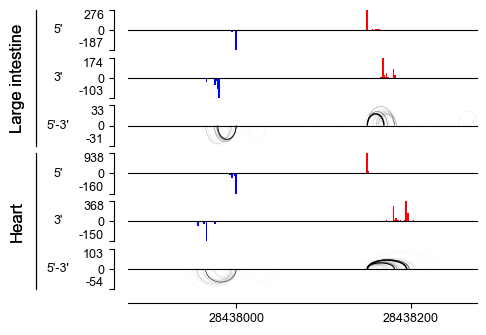

In [17]:
# Showcase one example

region = "chr1:28437900-28438250"
region = utils.expand_genomic_pos(region, 400)
fig = gv.plot_genome_view(
	region,
	data,
	formatters,
	coordinate_kw = {"major_coordinate_unit":200}
)
bpu.plt_change_figure_properties(
			fig,
			**{"fig_prop": {"size_inches":(4.5,3.9)},
			"fig_suptitle_kwargs": {"fontsize":bfontsize, "y":0.92},
			"locator_prop": {"nbins":2, "axis":"x"},
			"xticklabels_prop": {"fontsize":sfontsize},
			"yticklabels_prop": {"fontsize":sfontsize},
			"xlabel_prop": {"fontsize":bfontsize, "text":""},
			"ylabel_prop": {"fontsize":sfontsize, "text":""}
			},
			title_prop = {"text": ""}
		)

for i in range(len(data)):
	bpu.plt_change_figure_properties(
					fig,
					ax_targets=[i],
					ylabel_prop={"text":texts[i], "va": "center", "ha": "center"}
				)
	fig.axes[i].yaxis.set_label_coords(-0.2, 0.5)
		
	if i % 3 == 0:
		for s in example_samples:
			n = example_samples.index(s)
			row1, row2 = [3*n,3*n+2]
			y_center = (fig.axes[row1].get_position().y0 + fig.axes[row2].get_position().y1) / 2
			fig.text(-0.12, y_center, labels[s][1], va="center", ha="center", rotation="vertical", fontsize=bfontsize)
			line = mlines.Line2D([-0.08, -0.08], [fig.axes[row1].get_position().y1, fig.axes[row2].get_position().y0],
								 transform=fig.transFigure, color="#000000", linewidth=lw, zorder=10)
			fig.add_artist(line)

fig.savefig(f"{PROJECT_DIR_o2}figures/SuppFig9a.pdf", bbox_inches="tight", transparent=True)

# Individual patterns

In [18]:
def plot_one_distribution(d, t, ax, plot_xlabel=True, plot_ylabel=True):
	for s in tissues[t]:
		y = [pause_distances[(s, d)][i] for i in range(100)]
		ttl = sum(y)
		y = np.array(y) / sum(y)
		ax.plot(np.arange(100), y)

	ax.spines[["top", "right"]].set_visible(False)
	ax.set_title(t, fontsize=bfontsize)
	ax.tick_params(labelsize=sfontsize)
	if plot_xlabel:
		ax.set_xlabel("Pause distance", fontsize=bfontsize)
	if plot_ylabel:
		ax.set_ylabel("Frequency", fontsize=bfontsize)
		ax.yaxis.set_label_coords(-0.6, 0.5)

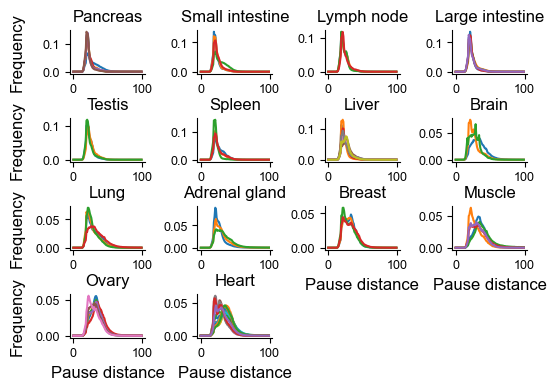

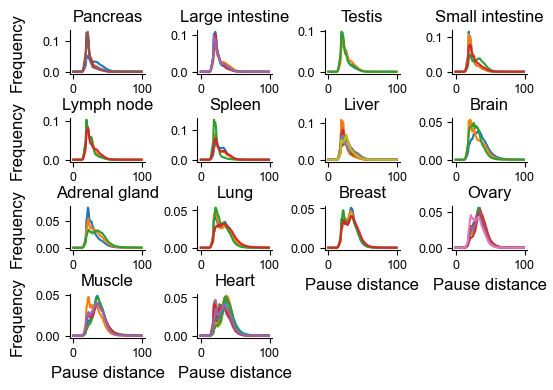

In [26]:
for d in ds:
	fig, ax = plt.subplots(4, 4, figsize=(5.9,4))
	for col in [2,3]:
		ax[3,col].axis("off")
	for t in medians_sorted[d]:
		row = list(medians_sorted[d]).index(t) // 4
		col = list(medians_sorted[d]).index(t) % 4
		if (row == 2 and col in [2,3]) or row == 3:
			plot_xlabel = True
		else:
			plot_xlabel = False
		plot_ylabel = True if col == 0 else False
		plot_one_distribution(d, t, ax[row, col], plot_xlabel, plot_ylabel)
	fig.subplots_adjust(wspace=0.7, hspace=1)
	figN = "d" if d == "distal" else "e"
	plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig9{figN}.pdf", bbox_inches="tight", transparent=True)